# Convolutional Neural Network - part B

In this notebook we will look a very quickl look at what convolutional layers learn

Goal of this lab is to:

* Visualize and understand what convolutional layer learns

# Optional project - reproducibility challenge

You are welcome to work on it during the lab if you have finished the exercises.

# Whiteboard exercises

# Setup

In [ ]:
# Boilerplate code to get started

%load_ext autoreload
%autoreload 
%matplotlib inline

import json
import matplotlib as mpl
from src import fmnist_utils
from src.fmnist_utils import *

def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

(x_train, y_train), (x_test, y_test) = fmnist_utils.get_data()

x_train_4d = x_train.view(-1, 1, 28, 28)
x_test_4d = x_test.view(-1, 1, 28, 28)

In [ ]:
## TODO: Random 

# Exercise 1: Convolution vs FC on FMNIST

* Fill out blanks in the code
* Train an MLP and a ConvNet for the supplied hyperparameters. Which one works better?

In [111]:
def build_conv(input_dim, output_dim, n_filters=32, hidden_dims=[32]):
    model = torch.nn.Sequential()
    
    # Convolution part
    ## TODO: Pick padding
    model.add_module("conv2d", torch.nn.Conv2d(input_dim[0], n_filters, kernel_size=5, padding=2))
    model.add_module("maxpool", torch.nn.MaxPool2d(2))
    model.add_module("relu", torch.nn.ReLU()) 
    ## TODO: Add layer flattening output to pass into linear layers
    model.add_module("flatten", Flatten())
    
    ## TODO: Determine this size
    previous_dim = n_filters *  input_dim[1]/2 * input_dim[2]/2
    
    # Classifier
    for id, D in enumerate(hidden_dims):
        model.add_module("linear_{}".format(id), torch.nn.Linear(previous_dim, D, bias=True))
        model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
        previous_dim = D
    model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))
    return model

In [ ]:
## Starting code for training a ConvNet.

input_dim = (1, 28, 28)

model = build_conv(input_dim, 10, n_filters=32)

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

H = train(loss=loss, model=model, x_train=x_train_4d, y_train=y_train,
          x_test=x_test_4d, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

plot(H)

 15%|█▌        | 15/100 [00:11<01:02,  1.36it/s]

In [62]:
# Starting code for training an MLP.

model = build_mlp(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H_mlp = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test, optim=optimizer, batch_size=128, n_epochs=100)

100%|██████████| 100/100 [00:06<00:00, 14.68it/s]


# Exercise 2: examine filters

1. Plot filters from model in exercise 2. Save them to file "9b_1.png".

2. Retrain model with shuffled labels. Does it still learn filters? What can you imply based on this experiment about how learning filters happens? Please save your answers to "9b_2.json".

In [ ]:
## TODO: Consider reuglarizing.

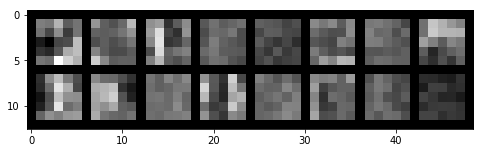

In [110]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt

def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

filters = list(model.modules())[0][0].weight.data
vistensor(filters, ch=0, allkernels=True)